<h1>2023 COMP3217 Security of CPS Coursework 2</h1>



<h2>Detection of Attacks on Power System Grids</h2>

Consider a power system framework configuration as shown below:

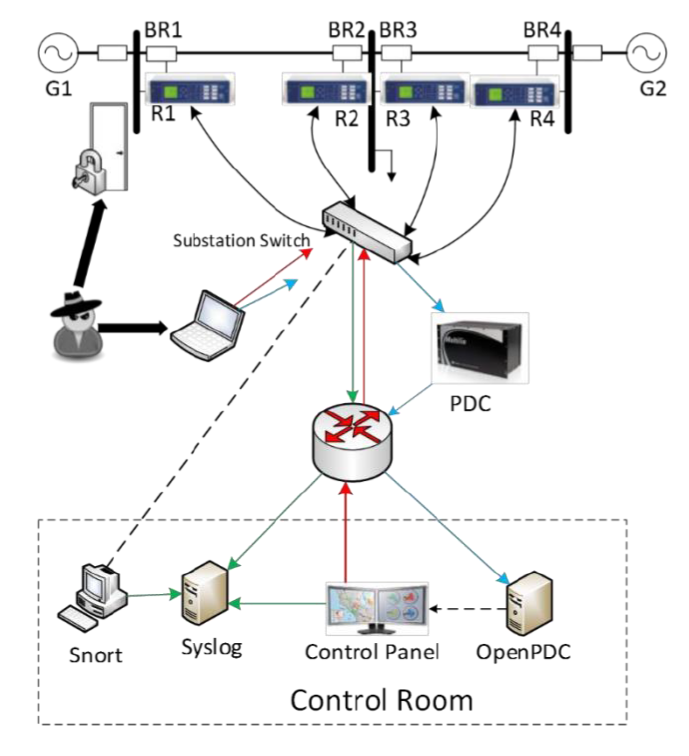

G1 and G2 are power generators. 

R1 through R4 are Intelligent Electronic Devices (IEDs) that can switch the breakers (BR1 to BR4) on or off. Each IED controls one breaker.

The IEDs use a distance protection scheme which trips the breaker on detected faults whether valid or fake since they have no internal validation to detect the difference. 

Operators can also manually issue commands to the IEDs to manually trip the breakers. Manual override is used when performing maintenance on the lines or other system components.   

The network has two lines: Line One spans from BR1 to BR2; Line Two spans from BR3 to BR4.

Three different type of sceneraios can occur in the system:
1. Service events/natural faults (maintentance downtime / short circuits)
2. Normal event (normal operation)
3. Remote cyber-attacks (data injection / remote tripping command injection)

The power grid measures its electrical waves by using Phasor Measurement Units (PMUs) or Synchrophasors. The system has 4 PMUs, with each PMU measuring 29 features, bringing the total PMU measurements to 116. 

<h2>Part A: Binary Event Classification</h2>

<h3>A.1 Problem Description</h3>

*Main idea is that the power system grid is prone to cyber-attacks that could cause black-outs, either through data injections to trigger faults (since there is no detection system in place to detect validity of data), or through remote-tripping command injections to manually override breaker control. Machine Learning will be used to train a binary classifier that can detect normal events and abnormal data injection attack events.

*Data availability: Training set with 6000 labelled system traces, 128 features per trace. Of the 128 features, 116 are PMU measurements and 12 are control panel logs, snort alerts and relay logs of the 4 PMUs. The event labels are 50% normal events, 50% abnormal data injection attack events. Test set has 100 unlabelled system traces. 

*Data format/volume: Both training set and test set are provided in .csv format. Training set (TrainingDataBinary.csv) has 6000rows x 129cols. The last column are event labels, with 0 indicating normal event, 1 indicating abnormal data injection event. Test set (TestingDataBinary.csv) has 100rows x 128cols.

*Feature analysis: Feature analysis could not be done as the columns were not indexed with details of the features. Only info provided is that there are 116 PMU measurements from 4 PMUs that measure 29 measurements each, and there are 12 control panel logs, snort alerts and relay logs from the 4 PMUs.

*Task: Use labelled training set to train a binary classifier. Use the trained classifier to run classification on the test set and get the best result. Store the labelled test set in TestingResultsbinary.csv. Analyse and discuss results of each trace in test set, in terms of training error and training accuracy. 

*Performance Metrics: Accuracy on the training data from cross validation.

<h3>A.2 ML Implementation</h3>

<h4>A.2.1 Step 1: Loading the Dataset</h4>

Firstly, we import pandas to utilize its data processing features, and other relevant libraries.

In [1]:
import pandas as pd

Then, we read in the .csv file of the training data. We need to specifiy in the parameters that the .csv file has no headers to fully load the 6000 system traces.  

In [2]:
trainDataBinary = pd.read_csv('data\TrainingDataBinary.csv', sep=',', header=None)
trainDataBinary.info() # to check whether data was correctly loaded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 129 entries, 0 to 128
dtypes: float64(113), int64(16)
memory usage: 5.9 MB


Here's the first five instances of the data set.

In [3]:
trainDataBinary.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,...,0,0,0,0,0,0,0,0,0,0
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,...,0,0,0,0,0,0,0,0,0,0
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,...,0,0,0,0,0,0,0,0,0,0
3,74.083443,130581.5902,-45.899649,130556.5169,-165.882741,130656.8100,72.152575,482.86107,-50.437475,499.15786,...,0,0,0,0,0,0,0,0,0,0
4,74.553268,131083.0556,-45.424094,131057.9823,-165.424375,131158.2754,72.118198,484.50906,-50.013486,497.69298,...,0,0,0,0,0,0,0,0,0,0


<h4>A.2.2 Step 2: Exploring the Dataset</h4>

Checking for NaN values

In [4]:
NaN_detected = False

for i in range(128):
    NaN_count = trainDataBinary[i].isnull().sum()
    if NaN_count != 0:
        print('Column' + i + 'has' + Nan_count + 'NaN values.\n')
        NaN_detected = True

if NaN_detected == False:
        print('No NaN values were detected.')

No NaN values were detected.


Data Visualisation showing 50-50 split on normal and abnormal events

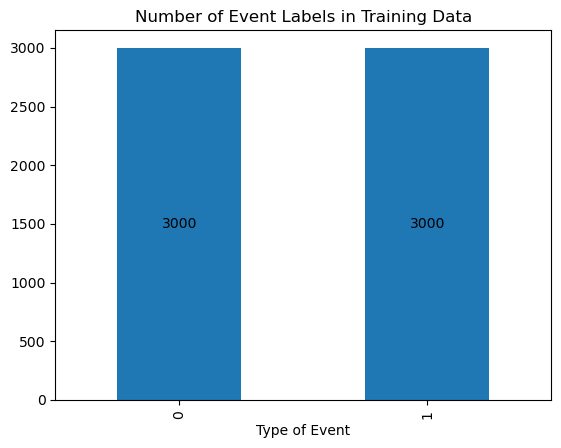

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt1 = trainDataBinary[128].value_counts().sort_values().plot(kind='bar', title='Number of Event Labels in Training Data', xlabel='Type of Event')
plt1.bar_label(plt1.containers[0], label_type = 'center')
plt.show()

From visual inspection of the data (i.e. from the first and last five data instances), we can observe that the features have different ranges. Therefore, normalization can be done to preprocess the data in the next step. 

In [11]:
trainDataBinary.tail()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
5995,116.889120,131860.3269,-3.076783,131810.1804,-123.094253,131910.4735,114.780635,376.10794,-5.254023,374.82617,...,0,0,0,0,0,0,0,0,0,0
5996,116.849013,131810.1804,-3.116890,131760.0339,-123.128630,131885.4002,114.769176,376.29105,-5.322778,374.82617,...,0,0,0,0,0,0,0,0,0,0
5997,116.384917,131734.9606,-3.586716,131684.8140,-123.586996,131785.1071,114.299351,376.47416,-5.849899,374.82617,...,0,0,0,0,0,0,0,0,0,0
5998,111.125164,130506.3704,-8.846468,130456.2238,-128.858208,130556.5169,106.667553,478.83265,-13.464508,477.73399,...,0,0,0,0,0,0,0,0,0,0
5999,110.878793,130481.2971,-9.092840,130456.2238,-129.104580,130556.5169,106.392533,478.83265,-13.750987,477.91710,...,0,0,0,0,0,0,0,0,0,0


For example, the next two figures will show how the range of two features differ from each other. 

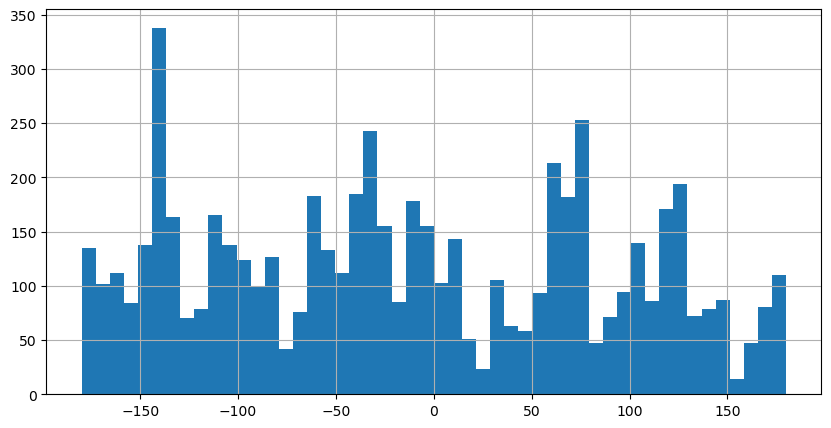

In [14]:
trainDataBinary[0].hist(bins=50, figsize=(10,5))
plt.show()

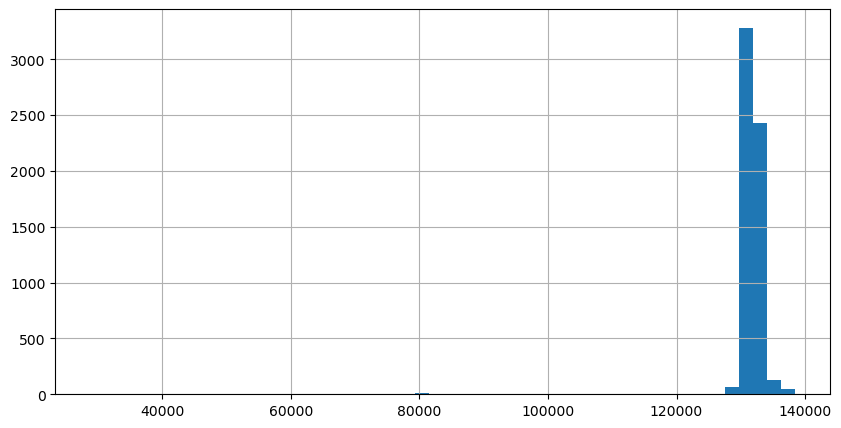

In [15]:
trainDataBinary[1].hist(bins=50, figsize=(10,5))
plt.show()

<h4>A.2.3 Step 3: Data Preprocessing</h4>

Firstly, we normalize all features in the training data.

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
trainDataBinary_scaled_np_arr = scaler.fit_transform(trainDataBinary)

In [21]:
trainDataBinary_scaled_df = pd.DataFrame(trainDataBinary_scaled_np_arr, columns=trainDataBinary.columns, index=trainDataBinary.index)

In [23]:
trainDataBinary_scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.695550,0.901876,0.362318,0.631352,0.028567,0.668470,0.682572,0.342334,0.341584,0.685726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.704686,0.925663,0.371407,0.720930,0.037739,0.749614,0.699640,0.273226,0.358409,0.547413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.704813,0.925892,0.371534,0.721792,0.037866,0.750386,0.699576,0.273226,0.358505,0.547413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705784,0.928408,0.372521,0.731266,0.038838,0.758887,0.700532,0.272812,0.359826,0.545400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.707089,0.932983,0.373842,0.748493,0.040111,0.774343,0.700436,0.273743,0.361004,0.543789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Compared to the unscaled data in code line 3.

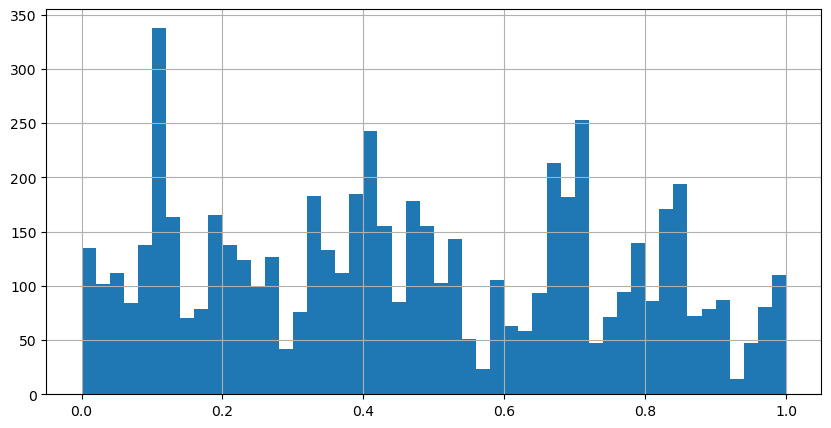

In [24]:
trainDataBinary_scaled_df[0].hist(bins=50, figsize=(10,5))
plt.show()

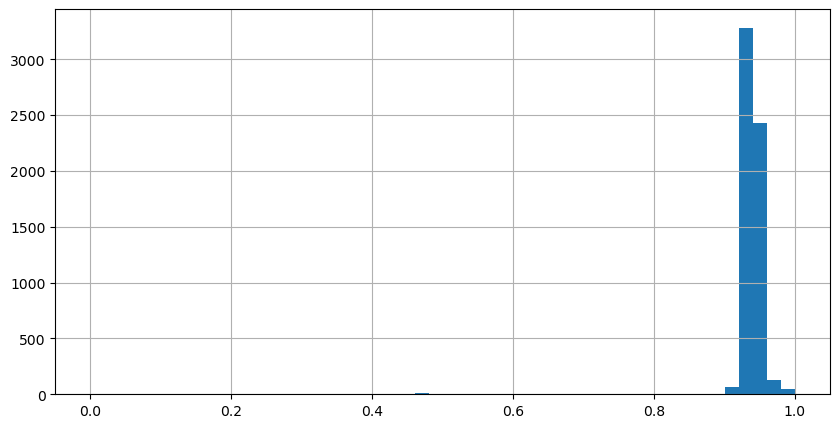

In [25]:
trainDataBinary_scaled_df[1].hist(bins=50, figsize=(10,5))
plt.show()

By normalizing the data through MinMax Scaling, the features now have the same range of between 0 and 1. 

Then we will do PCA for dimensionality reduction to eliminate redundant features.